# Introduction to Machine Learning via Nearest Neighbours


## Part 1 - Implement k-Nearest Neighbours (kNN) - 30 points

### Note:
This exercise closely follows the post by Scott Fortmann-Roe about bias-variance tradeoff (see references below). It is recommended that you think about each of the questions before referring to that essay.

In this exercise you will get familiar with a **non-parapmetric** learning algorithm called k-Nearest Neighbours (kNN), and will implement it. You will then analyse the bias-variance tradeoff and try to come up with the optimal kNN classifier for the given data.

For this exercise we will use hypothetical and artificial generated data.
### Nearest Neighbours
The kNN algorithm is simple - given a labeled sample set data, and a new sample, predict the label of this sample by using majority vote (or averaging) over the labels of the k-nearest neighbour of the new data in the sample set.

For this task, assume each data point is an n-dimensional point in $\mathbb{R}^n$, and each label is either 0 or 1.

Implement a class called KNNClassifier and two methods:
- `fit`: should recieve the training data (an array of shape [n_samples, n_features]) and their labels (array of shape [n_samples]). 
- `predict`: should recieve a set of data (an array of shape [n_samples, n_features]) and **return** their predicted labels (array of shape [n_samples]).

Use simple Euclidean distance to measure the distance between two points. In case two points in the training have the same distance from a given point to predict, the nearest would be the one appearing first in the training set. 

Use majority vote between all kNN of a point to predict its label. In case the vote of all kNN is tied, you may predict whichever label you wish.

You may look up [sklearn.neighbors.KNeighborsClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) for reference.

* Bonus for nurdes: use kd-tree for efficiency, see [nearest neighbour search in wiki](https://en.wikipedia.org/wiki/Nearest_neighbor_search)

* Bonus for lazy nurdes: use [scipy's kd implementation](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.spatial.KDTree.html)

In [2]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [3]:
class kNNClassifier:
  def __init__(self, n_neighbors):
    self.n_neighbors = n_neighbors
    
  def fit(self, X, y):
    self.X = X
    self.y = y

  def predict(self, X):
    dist_sq   = np.square(np.expand_dims(X,axis=1) - np.expand_dims(self.X, axis=0))
    dist_sum  = np.sum(dist_sq, axis=-1)
    dist_sqrt = np.sqrt(dist_sum)
    y_pred = []
    # going over all the points and comparing distance
    for r in np.arange(0, dist_sqrt.shape[0]):
      idx = dist_sqrt[r].argsort()[:self.n_neighbors]
      y_uniq,y_count =  np.unique(self.y[idx], return_counts=True)
      y_pred.append(y_uniq[y_count.argmax()])

    return np.array(y_pred)
  
  def update_n_neighbors(self,n_neighbors):
    self.n_neighbors = n_neighbors    

In [4]:
# Testing

arr = np.array(([0,0], [2,2], [3,3],[1,1],[6,6]))
X = np.array(([8,8],[1,1], [3,3],[5,5], [10,10]))
y = np.array([-1,1,1, -1, -1])

knn = kNNClassifier(3)
knn.fit(X,y)
print('Prediction:',knn.predict(arr))
print('Expectation: ', [ 1,1,1,1,-1])

Prediction: [ 1  1  1  1 -1]
Expectation:  [1, 1, 1, 1, -1]


## Part 2 - Learn and evaluate kNN algorithm on artificial data

kNN is a **non-parametric** in the sense that no inner parameter of the model is learned by the sample training set (or maybe you could say that the number of parameters increases with the size of the sample set). However, the number of neighbours **k is considered a hyper-parameter**, and choosing the optimal value for it, is choosing the balance between bias and variance as discussed in class.




### An applied example: voter party registration

In this example, each voter is described by a vector of two features $(x_0, x_1)$, where $x_0$ describes how wealthy that voter is, and $x_1$ describes how religious the voter is. Label $y=1$ represents a Republican voter, and $y=-1$ represents a Democrat voter.

Use the given function `generate_data(m)` to create m samples with m labels. The labels are created using the following function:

$$
y = \text{sign}\left(x_1 - 0.1\times((x_0-5)^3-x_0^2+(x_0 − 6)^2+80)\right)
$$

and then a small fraction of the labels (chosen randomly, up to 10%) are flipped to represent unknown effect of features which are not measured. The sign of 0 is defined as 1 for this case.


Below is an example of generating 500 samples, and plotting them.

In [5]:
def true_boundary_voting_pred(wealth, religiousness):
  return religiousness-0.1*((wealth-5)**3-wealth**2+(wealth-6)**2+80)

def generate_data(m, seed=14):
  # if seed is not None, this function will always generate the same data
  np.random.seed(seed) 
  
  X = np.random.uniform(low=0.0, high=10.0, size=(m,2))
  y = np.sign(true_boundary_voting_pred(X[:,0], X[:,1]))
 
  samples_to_flip = np.random.randint(0,m//10)
  flip_ind = np.random.choice(m, samples_to_flip, replace=False)
  y[flip_ind] = -y[flip_ind]
  return X, y

def plot_labeled_data(X, y, no_titles=False):
  republicans = (y==1)
  democrats = (y==-1)
  plt.scatter(X[republicans,0], X[republicans,1], c='r')
  plt.scatter(X[democrats,0], X[democrats,1], c='b')
  if not no_titles:
    plt.xlabel('Wealth')
    plt.ylabel('Religiousness')
    plt.title('Red circles represent Republicans, Blues Democrats')
    
  plt.xlim([0, 10]);
  plt.ylim([0, 10]);
  plt.plot(np.linspace(0,10,1000), -true_boundary_voting_pred(np.linspace(0,10,1000), np.zeros(1000)), linewidth=2, c='k');

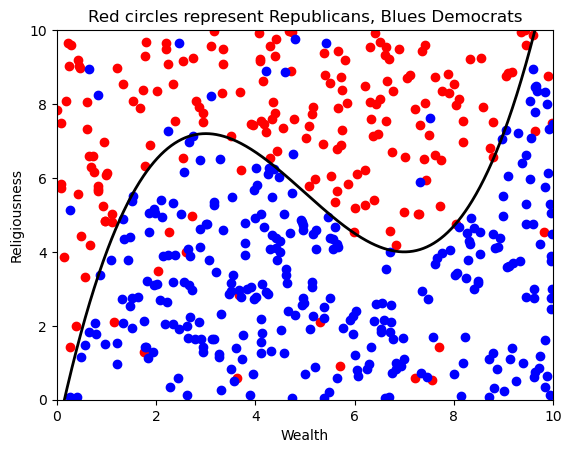

In [6]:
X, y = generate_data(m=500)
knn = kNNClassifier(2)
knn.fit(X,y)
knn.predict(X)
plot_labeled_data(X,y)


### 1. Analyse the properties of kNN - 30 points
Generate multiple sample data sets of size 500 (use the given function above), and plot the decision plane for increasing values of k (e.g.: 1, 3, 5, 11, 21, 51, 99).

The decision plane should cover the range [0,10] for both axes, coloring the patches that would be classified as Republicans or Democrats in two colors. It should look something like this:

![decision plane](https://doc-14-14-docs.googleusercontent.com/docs/securesc/flg80o8vb463a3nd3i6da8hemig5me1b/hvii8ll4dscju8o17vuo2aab9aei8hgr/1543334400000/11934753179242311747/03422859225809857490/1chmyojft_R6ftfBhoPZuGN9AykyUS-cw?e=view&nonce=4i4j8lssjk6kc&user=03422859225809857490&hash=k9ogjg94ssot1vocu8uoeg4okkeekg6f)

https://drive.google.com/file/d/1chmyojft_R6ftfBhoPZuGN9AykyUS-cw/view?usp=sharing

Answer the following questions:
- How is the decision plain affected from changes in the sample set, as a function of k?
- Can you describe when do you underfit or overfit the data? 
- How does the complexity of this model depends on k?

* Bonus for nurdes:
Use interactive slider for k to see the effect [see [interact](https://ipywidgets.readthedocs.io/en/stable/examples/Using%20Interact.html)]

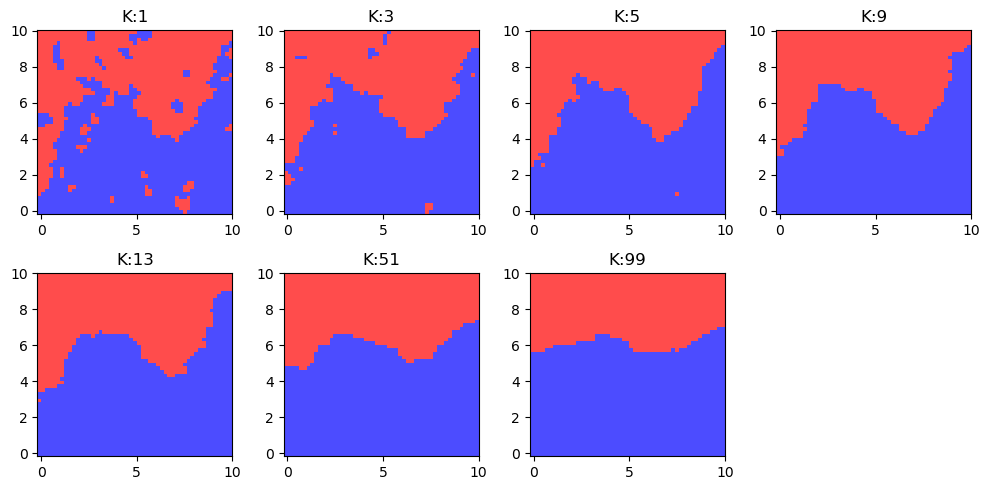

In [8]:
from matplotlib.colors import ListedColormap
cmap_ = ListedColormap(['blue','red'])



def get_knn_plot_data(n_neighbors, X, y):
    knn = kNNClassifier(n_neighbors)
    knn.fit(X, y)

    mesh_size = 0.2
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, mesh_size),
                         np.arange(y_min, y_max, mesh_size))
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    return xx,yy,Z
    

X, y = generate_data(m=500,)
plt.figure(figsize=(10, 5))
for i,k in enumerate([1,3,5,9,13,51,99]):
    xx,yy,Z = get_knn_plot_data(k, X,y)

    plt.subplot(2,4,i+1)
    plt.pcolormesh(xx,yy, Z, cmap=cmap_, alpha=0.7)
    plt.title('K:'+ str(k))    

plt.tight_layout();





Answer the following questions:
- How is the decision plain affected from changes in the sample set, as a function of k?<br>
```As K increases the decision plane loses it's complexity, the line that separates between the regions becomes more and more linear almost flat```

- Can you describe when do you underfit or overfit the data?<br>
```When K is equal or smaller than 5, our model describes our data very accurately meaning overfitting.```<br> 
```As k increases above 9 we underfit, to elaborate:  If our data has more republicans than democrats, As our K increases our model will predict more and more republicans because of our data bias.```
- How does the complexity of this model depends on k?<br>
```As K increases the complexity decreases```

### 2. Finding the optimal k - 15 points
* Sample a single sample set of size 1000 and divide it randomly to train (0.6) / validation (0.2) / test (0.2) sets. 
* Plot the train vs validation error for several k values, and choose the best k. Where do you underfit/overfit the data? 
* Finally, estimate the generalization error of your chosen classifier using the test set. What would happen if you optimize directly on test? is the optimal k the same?


Sample a single sample set of size 1000 and divide it randomly to train (0.6) / validation (0.2) / test (0.2) sets. 

In [10]:
# code goes here
from sklearn.model_selection import train_test_split
X, y = generate_data(m=1000)

X_train, X_val_and_test, y_train, y_val_and_test = train_test_split(X, y, test_size=0.4)
X_val, X_test, y_val, y_test = train_test_split(X_val_and_test, y_val_and_test, test_size=0.5)

print(X_train.shape, X_val.shape, y_test.shape)

(600, 2) (200, 2) (200,)


Plot the train vs validation error for several k values, and choose the best k. Where do you underfit/overfit the data? 

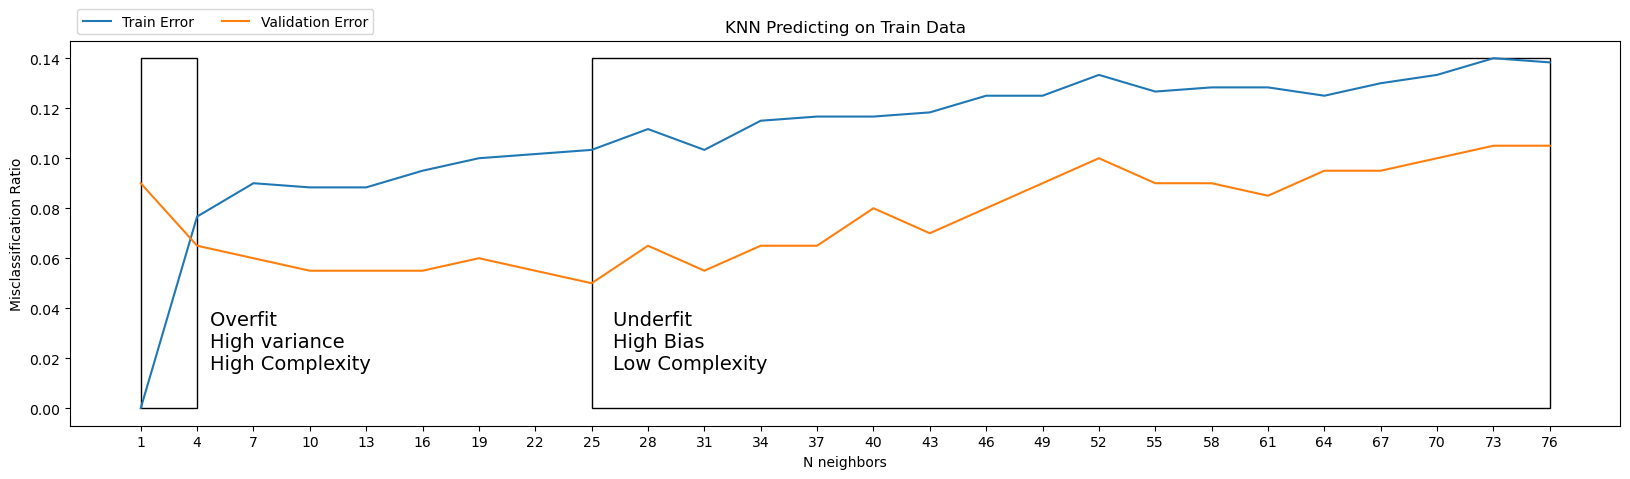

In [23]:
knn = kNNClassifier(3)
knn.fit(X_train, y_train)

k_vals = range(1,79,3)

#calculating error rate
train_errors = []
val_errors = []
for k in k_vals:
        knn.update_n_neighbors(k)
        y_pred_train = knn.predict(X_train)
        y_pred_val   = knn.predict(X_val)

        error_train  = np.mean(y_train != y_pred_train)
        error_val    = np.mean(y_val != y_pred_val)
        
        train_errors.append([k,error_train])
        val_errors.append([k,error_val])

train_errors = np.array(train_errors)
val_errors   = np.array(val_errors)


n = train_errors.shape[0]

max_error = np.max(train_errors[:,1].max(axis=0))

# Creating plot
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)

plt.plot(np.arange(n),train_errors[:,1], label='Train Error' )
plt.plot(np.arange(n),val_errors[:,1], label='Validation Error')

# Overfit rect
rectangle = plt.Rectangle((0,0),1, max_error, fill=False)
plt.gca().add_patch(rectangle)
props = dict(boxstyle='round', alpha=0)
ax.text(0.09, 0.3, 'Overfit \nHigh variance\nHigh Complexity', transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)


# Underfit rect
rectangle = plt.Rectangle((8,0),17, max_error, fill=False)
plt.gca().add_patch(rectangle)
ax.text(0.35, 0.3, 'Underfit \nHigh Bias\nLow Complexity', transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.xticks(np.arange(n), train_errors[:,0].astype('int'))
plt.xlabel('N neighbors')
plt.ylabel('Misclassification Ratio')
plt.title('KNN Predicting on Train Data')
# Function add a legend  
plt.legend(bbox_to_anchor =(0.2, 1.1), ncol = 2)
plt.show()


It seems 25 is the lowest point in validation, lets make sure.

In [24]:
val_optimal_k, val_error_rate = val_errors[val_errors[:,1].argmin()]
print('The optimal K value in validation is:', int(val_optimal_k), ' with error rate of:', val_error_rate,'\n')

The optimal K value in validation is: 25  with error rate of: 0.05 



Where do you overfit\underfit?<br>
```We overfit when k is small (1 - 4) and thus have high complexity, we underfit when k is larger than 25```

Choose the best k:<br>
```Our best k is 25 since it's the lowest point in our validation.```


Estimate the generalization error of your chosen classifier using the test set. 

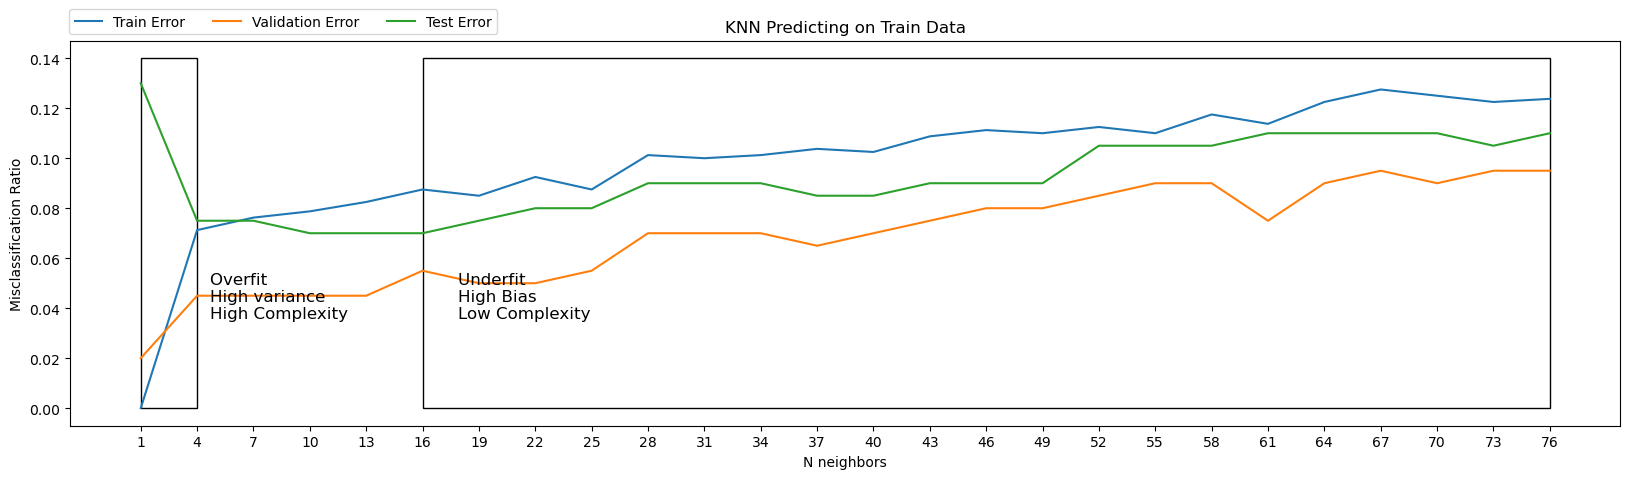

In [34]:
knn = kNNClassifier(3)
knn.fit(X_train, y_train)

k_vals = range(1,79,3)

#calculating error rate

train_errors = []
val_errors   = []
test_errors  = []
for k in k_vals:
        knn.update_n_neighbors(k)
        y_pred_train = knn.predict(X_train)
        y_pred_val = knn.predict(X_val)
        y_pred_test = knn.predict(X_test)

        error_train = np.mean(y_train != y_pred_train)
        error_val = np.mean(y_val != y_pred_val)
        error_test = np.mean(y_test != y_pred_test)

        train_errors.append([k,error_train])
        val_errors.append([k,error_val])
        test_errors.append([k,error_test])

train_errors = np.array(train_errors)
val_errors   = np.array(val_errors)
test_errors   = np.array(test_errors)



# Creating plot
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)

plt.plot(np.arange(n),train_errors[:,1], label='Train Error' )
plt.plot(np.arange(n),val_errors[:,1], label='Validation Error')
plt.plot(np.arange(n),test_errors[:,1], label='Test Error')

# Overfit rect
rectangle = plt.Rectangle((0,0),1, max_error, fill=False)
plt.gca().add_patch(rectangle)
props = dict(boxstyle='round', alpha=0)
ax.text(0.09, 0.4, 'Overfit \nHigh variance\nHigh Complexity', transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)


# Underfit rect
rectangle = plt.Rectangle((5,0),20, max_error, fill=False)
plt.gca().add_patch(rectangle)
ax.text(0.25, 0.4, 'Underfit \nHigh Bias\nLow Complexity', transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

plt.xticks(np.arange(n), train_errors[:,0].astype('int'))
plt.xlabel('N neighbors')
plt.ylabel('Misclassification Ratio')
plt.title('KNN Predicting on Train Data')
# Function add a legend  
plt.legend(bbox_to_anchor =(0.28, 1.1), ncol = 3)
plt.show()





In [ ]:
# Trying optimal K val in predicting X_test
knn.update_n_neighbors(int(val_optimal_k))
y_pred_test = knn.predict(X_test)

test_error = np.mean(y_test != y_pred_test)
print('validation error:',val_error_rate)
print('test error:',test_error)

validation error: 0.05
test error: 0.08


What would happen if you optimize directly on test? <br>
```If we would have optimized on test, our best k might have been 13 or 7, both have a score of 0.06.```

is the optimal k the same?<br>
```No, validation optimal K is 25``` 

### 3. Using cross validation - 25 points
* This time, put the test data aside (0.2 of the data), and apply 5-fold CV on the remaining data to evaluate the performance of each k value. 

In [30]:
# code goes here
from sklearn.model_selection import KFold
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


kf = KFold(n_splits=5)

k_vals = np.arange(1,79,3)
train_errors = []
val_errors   = []

train_mean_score = []
val_mean_score = []
accuracies = []
# train and evaluate a KNN model for each value of k
knn = kNNClassifier(n_neighbors=k)
# use the k-fold cross-validation iterator to train and evaluate the model
for k in k_vals:
    knn.update_n_neighbors(k)
    split_error_train = []
    split_error_val   = []
    for train_indices, val_indices in kf.split(X_train):
        knn.fit(X_train[train_indices], y_train[train_indices])
        y_pred_train = knn.predict(X_train[train_indices])
        y_pred_val   = knn.predict(X_train[val_indices])
        

        split_error_train.append(np.mean(y_train[train_indices] != y_pred_train))
        split_error_val.append(np.mean(y_train[val_indices] != y_pred_val))



    train_errors.append(np.mean(split_error_train))
    val_errors.append(np.mean(split_error_val))
train_errors = np.array(train_errors)
val_errors =np.array(val_errors)
# best_k = k_vals[train_errors.index(max(mean_score))]
print('best k:', k_vals[val_errors.argmin()])

model = kNNClassifier(n_neighbors=k_vals[val_errors.argmin()])
model.fit(X_train,y_train)
y_pred_test = model.predict(X_test)

test_error = np.mean(y_test != y_pred_test)

print('test error:',test_error)



best k: 10
test error: 0.07


What is the size of the validation and train set now, in each CV iteration? <br>
```The size of each CV is 160```

Why?<br>
```By spreading our estimations to different parts we can lower the variance of our estimator thus lowering the chance of overfitting```


## References
- http://scott.fortmann-roe.com/docs/BiasVariance.html
- http://scott.fortmann-roe.com/docs/MeasuringError.html
- http://scikit-learn.org/stable/modules/cross_validation.html